In [1]:
import pandas as pd
import numpy as np

from sklearn import feature_selection, pipeline, svm, model_selection, metrics

from skopt import BayesSearchCV

np.int = int  # fix for skopt

import datamol as dm

**Далее, всё, что относится к fps помечено подписью fps, например, X_train_fps, иначе переменная относится к дескрипторам и обозначается X_train** 

In [2]:
kf = model_selection.RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

## удаление повторов + создание матриц для обучения и теста

In [3]:
df_train = pd.read_csv("logP-14000.csv").dropna()

smi = df_train.SMILES
len(smi)

14163

In [4]:
list_smi_canon = []

for smiles in smi:
    mol = dm.to_mol(smiles)
    canon_smi = dm.to_smiles(mol, canonical=True)
    list_smi_canon.append(canon_smi)

len(list_smi_canon)

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


14163

In [5]:
df_train.insert(1, "canon_smi", list_smi_canon, False)  # добавтъили колонку

df_train.drop_duplicates(
    subset="canon_smi", keep="first", inplace=True
)  # удалили дубликаты, оставляя только первое входящее вещество

y_train = df_train.Kow
X_train = df_train.iloc[:, 5:]  # дф для тренировки с дескрипторами

### создание fps для Popova

In [6]:
smiles_Popova = df_train.SMILES

mols_Popova = [dm.to_mol(smiles) for smiles in smiles_Popova]

fps_Popova = [dm.to_fp(mol) for mol in mols_Popova]

X_train_fps = pd.DataFrame(data=np.array(fps_Popova))
X_train_fps

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14136,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### создание fps для Martel

In [7]:
df_test = pd.read_csv("logP-707-Martel.csv")

y_test = df_test.logPow
X_test = df_test.iloc[:, 3:]  # дф для теста на дескрипторах

In [8]:
smiles_Martel = df_test.SMILES

mols_Martel = [dm.to_mol(smiles) for smiles in smiles_Martel]

fps_Martel = [dm.to_fp(mol) for mol in mols_Martel]

X_test_fps = pd.DataFrame(data=np.array(fps_Martel))
X_test_fps

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
704,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## проверка на соответствие молекул из статьи

In [9]:
MAIN_MOLS = pd.read_csv(
    "MOLS.csv"
)  # работает только на ядре 3.12.1, которе не стоит в рекомендованном
smiles = MAIN_MOLS.SMILES
names = list(MAIN_MOLS.NAME)
names

['Lycorine',
 'Apiol',
 'Dillapiol',
 'ATMB',
 'Myristicin',
 'TPP–apiol',
 'TPP–dillapiol',
 'TPP–ATMB',
 'Propyl–TPP',
 'Allylbenzene',
 'Estragole',
 'Eugenol',
 '1-allyl-1.2.4-triazol',
 '2.5-dimethoxy-3.4-methylenedioxy-4′-methoxychalcon',
 '2.5-dimethoxy-3.4-methylenedioxy-4′.5′-methylenedioxychalcon',
 '2.5-dimethoxy-3.4-methylenedioxy-4′-fluorochalcon']

In [10]:
mols = [dm.to_mol(smiles) for smiles in smiles]

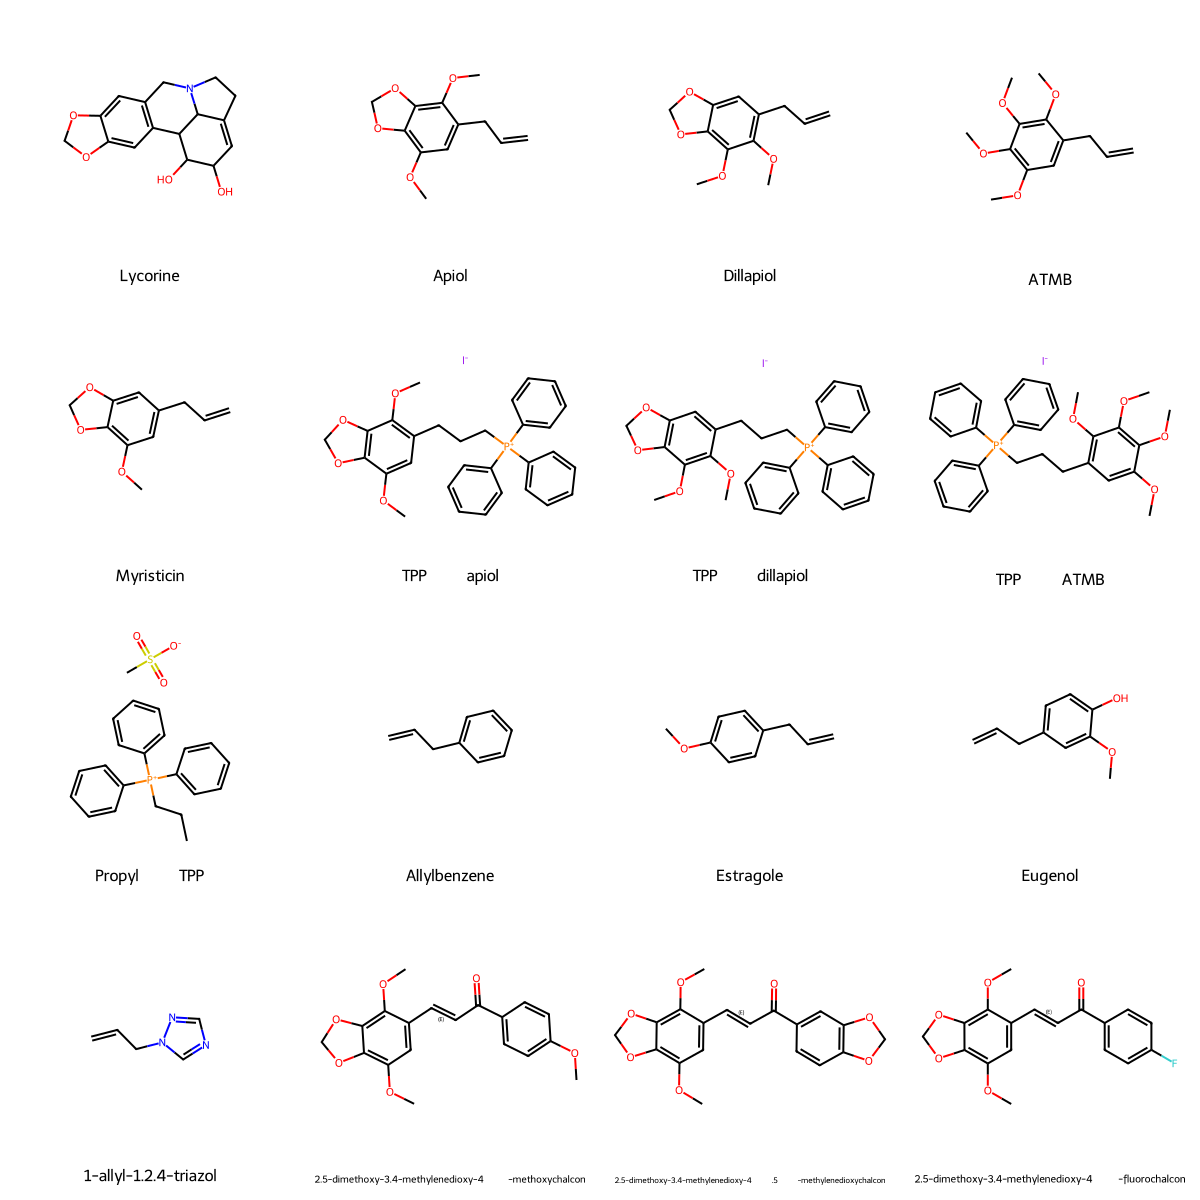

In [11]:
dm.to_image(mols=mols, legends=names)

In [ ]:
fps_16 = [dm.to_fp(mol) for mol in mols]

X_test_fps_16 = pd.DataFrame(data=np.array(fps_16))
X_test_fps_16

## подбор параметров FPS + обуение на Popva и валидация на Martel

In [12]:
svr = svm.SVR()

In [16]:
narrow_grid_fps = {
    "C": np.linspace(1, 3, 5),  ##параметр регуляризации - степень 2
    "epsilon": 10 ** np.linspace(-3, 0, 4),  ##полуширина трубки
}

In [17]:
gs_2 = model_selection.GridSearchCV(
    svr,
    narrow_grid_fps,
    verbose=3,
    n_jobs=-1,
    cv=kf,
)

In [18]:
gs_2.fit(X_train_fps, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[CV 1/5] END ................C=1.0, epsilon=1.0;, score=0.759 total time= 2.8min
[CV 2/5] END ................C=1.0, epsilon=1.0;, score=0.746 total time= 2.8min
[CV 3/5] END ................C=1.0, epsilon=1.0;, score=0.764 total time= 2.9min
[CV 5/5] END ................C=1.0, epsilon=1.0;, score=0.755 total time= 2.9min
[CV 4/5] END ................C=1.0, epsilon=1.0;, score=0.753 total time= 2.9min
[CV 3/5] END ................C=1.0, epsilon=0.1;, score=0.833 total time=17.4min
[CV 4/5] END ................C=1.0, epsilon=0.1;, score=0.821 total time=17.8min
[CV 1/5] END ................C=1.0, epsilon=0.1;, score=0.815 total time=17.8min
[CV 2/5] END ................C=1.0, epsilon=0.1;, score=0.811 total time=18.6min
[CV 5/5] END ................C=1.0, epsilon=0.1;, score=0.831 total time=19.3min
[CV 3/5] END ...............C=1.0, epsilon=0.01;, score=0.834 total time=23.9min
[CV 1/5] END ...............C=1.0, epsilon=0.01;, score=0.816 total time=24.9min
[CV 3/5] END ..............C

GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=42),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([1. , 1.5, 2. , 2.5, 3. ]),
                         'epsilon': array([0.001, 0.01 , 0.1  , 1.   ])},
             verbose=3)

In [19]:
gs_2.best_params_, gs_2.best_score_

({'C': 3.0, 'epsilon': 0.001}, 0.8546751094391121)

### оказалось. что старые гиперпараметры не очень хоррошо подходят, поэтому используем новые

In [29]:
grid = {
    "C": (5, 20),
    "epsilon": (0.001, 0.1),
}

In [26]:
opt = BayesSearchCV(
    svr, grid, cv=kf, n_jobs=-1, scoring="r2", verbose=3, n_iter=15, random_state=42
)

In [30]:
opt.fit(X_train_fps, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV 2/5] END .C=11, epsilon=0.07304484857455519;, score=0.847 total time=12.6min
[CV 4/5] END .C=11, epsilon=0.07304484857455519;, score=0.855 total time=12.6min
[CV 1/5] END .C=11, epsilon=0.07304484857455519;, score=0.858 total time=12.7min
[CV 3/5] END .C=11, epsilon=0.07304484857455519;, score=0.867 total time=12.8min
[CV 5/5] END .C=11, epsilon=0.07304484857455519;, score=0.856 total time=12.8min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END .C=18, epsilon=0.08844821246070536;, score=0.854 total time=12.2min
[CV 2/5] END .C=18, epsilon=0.08844821246070536;, score=0.847 total time=12.3min
[CV 1/5] END .C=18, epsilon=0.08844821246070536;, score=0.856 total time=12.3min
[CV 3/5] END .C=18, epsilon=0.08844821246070536;, score=0.866 total time=12.3min
[CV 4/5] END .C=18, epsilon=0.08844821246070536;, score=0.852 total time=12.4min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 4/5] END .C=12, epsilon=0.09195352964526833;, score=0.853 total time

KeyboardInterrupt: 

In [ ]:
opt.best_score_, opt.best_params_

In [31]:
model_fps = svm.SVR(epsilon=0.007, C=14)

model_fps.fit(X_train_fps, y_train)

SVR(C=14, epsilon=0.007)

In [ ]:
import pickle

# Save the model
with open("model_fps.pkl", "wb") as f:
    pickle.dump(model_fps, f)

# Load the model
with open("model_fps.pkl", "rb") as f:
    model_fps_2 = pickle.load(f)

In [39]:
model_fps.score(X_train_fps, y_train)  # R^2 исходный

0.9938060536627488

In [34]:
model_fps.score(X_test_fps, y_test)  # R^2 на Martel

-1.2643235322801551

In [36]:
metrics.mean_absolute_error(y_test, model_fps.predict(X_test_fps))

1.5494079735447541

In [42]:
model_fps_66 = svm.SVR(C=1.58, epsilon=0.054556)

model_fps_66.fit(X_train_fps, y_train)

SVR(C=1.58, epsilon=0.054556)

In [44]:
model_fps_66.score(X_test_fps, y_test)  # R^2 на Martel

-1.1984504914748535

## подбор параметров для обучения на дескрипторах

In [ ]:
gs_desc = model_selection.GridSearchCV(
    svr,
    narrow_grid_fps,
    verbose=3,
    n_jobs=-1,
    cv=kf,
)

In [ ]:
gs_desc.fit(X_train, y_train)

In [ ]:
gs_desc.best_score_, gs_desc.best_params_

In [45]:
model_desc = svm.SVR(C=1.58, epsilon=0.054556)

model_desc.fit(X_train, y_train)

SVR(C=1.58, epsilon=0.054556)

In [ ]:
# Save the model
with open("model_desc.pkl", "wb") as f:
    pickle.dump(model_desc, f)

# Load the model
with open("model_desc.pkl", "rb") as f:
    model_desc_2 = pickle.load(f)

In [49]:
model_desc.score(X_train, y_train)

-0.0018025546114519564

In [51]:
model_desc.score(X_test, y_test)

-3.46758533106964